# Streaming Image Files to Keras

Let's say we have a bunch of jpg files stored in a folder. I've written a class ImageStream that uses Pythonic indexing and iteration to stream through those files. The below cell creates an instance of ImageStream using the jpg files stored in image_folder. Calling frame_stream[i] returns an array that represents the pixel values of the i^th image in the folder. This is useful when the images of the folder represent a video.

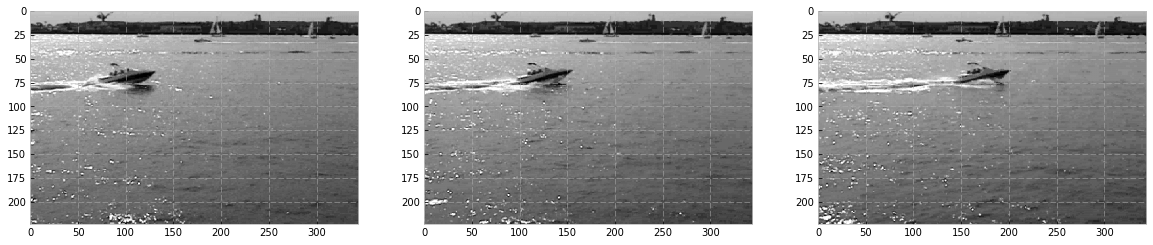

In [22]:
from image_stream import ImageStream
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

image_folder = './test_data/jpegs/boats'
frame_stream = ImageStream(image_folder, color=False)
fig , axs = plt.subplots(1, 3, figsize=(20,20)) 
axs[0].imshow(frame_stream[0], cmap='gray')
axs[1].imshow(frame_stream[5], cmap='gray')
axs[2].imshow(frame_stream[15], cmap='gray')

Let's load the images from the folder into a numpy array. This will make it easier to use them for training a neural network with Keras. When Keras is using the TensorFlow backend it will expect image arrays to be in the shape (num_images, y_dim, x_dim, num_channels). So in the below cell I load the boat images into the array X and reshape into the proper form.

In [50]:
X = np.array([img for img in frame_stream])
X = np.expand_dims(X, -1)
X.shape

(31, 224, 344, 1)

# Convolutional Autoencoders

Autoencoders are neural networks that take input data, form a compressed representation of that data in the hidden layers, then reconstruct the original input from the compressed input. Convolutional autoencoders are a special type of autoencoder that are well suited for forming compressed representations of images. The below image shows a 3x3 convolution layer operating on an image. The filter is dragged across the input image. The output image can either be the same size or smaller, depending on if the borders are padded or not.
<img src="https://i.stack.imgur.com/I7DBr.gif">

The below cell builds a convolutional autoencoder using Keras. The Conv2D function creates a 2D convolutional layer (a stack of convolutional filters) which can be added to the network. Keras trains the filter entries using back propagation. The MaxPooling2D layer is responsible for compressing the image. This layer consists of a single nonlinear filter of size pool_size (the below example has pool_size=(2,2)). The max pooling layer drags this filter across the input image and outputs the max pixel value in each 2x2 square of the image.

In [48]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(*frame_stream.shape, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [49]:
autoencoder.fit(X, X)

ValueError: Error when checking model target: expected conv2d_21 to have shape (None, 220, 340, 1) but got array with shape (31, 224, 344, 1)

In [45]:
frame_stream.shape

(224, 344)

In [46]:
X.shape

(31, 224, 344, 1)